# 🛠️ CMAPSS RUL Prediction Pipeline
A complete end-to-end pipeline using traditional ML and LSTM models.

## 📥 Step 1: Load CMAPSS Data

In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

# Load training data
train_paths = [
    '/content/drive/My Drive/CMAPSS_Project/data_set/train_FD001.csv',
    '/content/drive/My Drive/CMAPSS_Project/data_set/train_FD002.csv',
    '/content/drive/My Drive/CMAPSS_Project/data_set/train_FD003.csv',
    '/content/drive/My Drive/CMAPSS_Project/data_set/train_FD004.csv'
]
train_dfs = [pd.read_csv(path, sep='\s+', header=None) for path in train_paths]
train_data = pd.concat(train_dfs, ignore_index=True)

# Load RUL data
rul_paths = [
    '/content/drive/My Drive/CMAPSS_Project/data_set/RUL_FD001.csv',
    '/content/drive/My Drive/CMAPSS_Project/data_set/RUL_FD002.csv',
    '/content/drive/My Drive/CMAPSS_Project/data_set/RUL_FD003.csv',
    '/content/drive/My Drive/CMAPSS_Project/data_set/RUL_FD004.csv'
]
rul_dfs = [pd.read_csv(path, sep='\s+', header=None) for path in rul_paths]
rul_data = pd.concat(rul_dfs, ignore_index=True)

# Assign column names
train_data.columns = ['Engine ID', 'Cycle'] + [f'Sensor {i}' for i in range(1, 24 + 1)]
rul_data.columns = ['RUL']

print(train_data.head())
print(rul_data.head())


Mounted at /content/drive
   Engine ID  Cycle  Sensor 1  Sensor 2  Sensor 3  Sensor 4  Sensor 5  \
0          1      1   -0.0007   -0.0004     100.0    518.67    641.82   
1          1      2    0.0019   -0.0003     100.0    518.67    642.15   
2          1      3   -0.0043    0.0003     100.0    518.67    642.35   
3          1      4    0.0007    0.0000     100.0    518.67    642.35   
4          1      5   -0.0019   -0.0002     100.0    518.67    642.37   

   Sensor 6  Sensor 7  Sensor 8  ...  Sensor 15  Sensor 16  Sensor 17  \
0   1589.70   1400.60     14.62  ...     521.66    2388.02    8138.62   
1   1591.82   1403.14     14.62  ...     522.28    2388.07    8131.49   
2   1587.99   1404.20     14.62  ...     522.42    2388.03    8133.23   
3   1582.79   1401.87     14.62  ...     522.86    2388.08    8133.83   
4   1582.85   1406.22     14.62  ...     522.19    2388.04    8133.80   

   Sensor 18  Sensor 19  Sensor 20  Sensor 21  Sensor 22  Sensor 23  Sensor 24  
0     8.4195   

## ⚙️ Step 2: Preprocess and Engineer Features

In [3]:
from sklearn.preprocessing import MinMaxScaler

def add_lag_features(df, sensor_columns, lag_size=3):
    lag_features = []

    for sensor in sensor_columns:
        for lag in range(1, lag_size + 1):
            lag_col = df.groupby("Engine ID")[sensor].shift(lag)
            lag_col.name = f'{sensor}_Lag{lag}'
            lag_features.append(lag_col)

    lag_df = pd.concat(lag_features, axis=1)
    return pd.concat([df, lag_df], axis=1).bfill()

def preprocess_train_data(train_data, window_size=5, lag_size=3):
    sensor_columns = [col for col in train_data.columns if 'Sensor' in col]

    scaler = MinMaxScaler()
    train_data[sensor_columns] = scaler.fit_transform(train_data[sensor_columns])
    train_data.bfill(inplace=True)

    for sensor in sensor_columns:
        train_data[f'{sensor}_RollingMean'] = train_data.groupby('Engine ID')[sensor].transform(
            lambda x: x.rolling(window=window_size, min_periods=1).mean())
        train_data[f'{sensor}_RollingStd'] = train_data.groupby('Engine ID')[sensor].transform(
            lambda x: x.rolling(window=window_size, min_periods=1).std())
    train_data.bfill(inplace=True)

    train_data = add_lag_features(train_data, sensor_columns, lag_size)

    return train_data

## 🤖 Step 3: LSTM Model for RUL Prediction

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# --- Function: Add RUL if missing ---
def add_rul(df):
    df = df.copy()
    max_cycles = df.groupby("Engine ID")["Cycle"].transform("max")
    df["RUL"] = max_cycles - df["Cycle"]
    return df

# --- Function: Normalize features per engine ---
def normalize_per_engine(df, feature_cols):
    df_scaled = df.copy()
    df_scaled[feature_cols] = df_scaled[feature_cols].astype(float)  # Avoid dtype warning
    for eid in df_scaled['Engine ID'].unique():
        mask = df_scaled['Engine ID'] == eid
        df_scaled.loc[mask, feature_cols] = MinMaxScaler().fit_transform(df_scaled.loc[mask, feature_cols])
    return df_scaled

# --- Function: Create sequences for LSTM ---
def create_sequences(data, seq_len, feature_cols):
    X, y = [], []
    for eid in data['Engine ID'].unique():
        edf = data[data['Engine ID'] == eid].sort_values('Cycle')
        for i in range(len(edf) - seq_len):
            X.append(edf.iloc[i:i+seq_len][feature_cols].values)
            y.append(edf.iloc[i+seq_len]['RUL'])
    return np.array(X), np.array(y)

# --- Preprocess Input Data ---
train_data = add_rul(train_data)  # <-- Adds RUL if missing

seq_length = 30
feature_cols = [col for col in train_data.columns if col not in ['Engine ID', 'Cycle', 'RUL']]

# Normalize features
train_scaled = normalize_per_engine(train_data.copy(), feature_cols)
train_scaled[['Engine ID', 'Cycle', 'RUL']] = train_data[['Engine ID', 'Cycle', 'RUL']]  # Keep original ID/Cycle/RUL

# Create sequences
X_seq, y_seq = create_sequences(train_scaled, seq_length, feature_cols)
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# --- LSTM Model Definition ---
model_lstm = Sequential([
    LSTM(64, input_shape=(seq_length, X_train_seq.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# --- Training ---
history = model_lstm.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- Evaluation ---
y_pred_lstm = model_lstm.predict(X_test_seq).flatten()
mse_lstm = mean_squared_error(y_test_seq, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)

print(f"LSTM - MSE: {mse_lstm:.2f}, MAE: {mae_lstm:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
3052/3052 ━━━━━━━━━━━━━━━━━━━━ 121s 38ms/step - loss: 27336.7871 - val_loss: 13911.4854
Epoch 2/30
3052/3052 ━━━━━━━━━━━━━━━━━━━━ 113s 37ms/step - loss: 12009.7354 - val_loss: 9095.7227
Epoch 3/30
3052/3052 ━━━━━━━━━━━━━━━━━━━━ 141s 37ms/step - loss: 9208.3203 - val_loss: 8879.8730
Epoch 4/30
3052/3052 ━━━━━━━━━━━━━━━━━━━━ 144s 37ms/step - loss: 9082.5049 - val_loss: 8877.4014
Epoch 5/30
3052/3052 ━━━━━━━━━━━━━━━━━━━━ 145s 38ms/step - loss: 9109.6680 - val_loss: 8574.9678
Epoch 6/30
3052/3052 ━━━━━━━━━━━━━━━━━━━━ 138s 37ms/step - loss: 8752.4707 - val_loss: 6819.2886
Epoch 7/30
3052/3052 ━━━━━━━━━━━━━━━━━━━━ 113s 37ms/step - loss: 6794.1270 - val_loss: 6342.6021
Epoch 8/30
3052/3052 ━━━━━━━━━━━━━━━━━━━━ 142s 37ms/step - loss: 5678.2021 - val_loss: 4732.9722
Epoch 9/30
3052/3052 ━━━━━━━━━━━━━━━━━━━━ 139s 36ms/step - loss: 5064.1880 - val_loss: 4226.3877
Epoch 10/30
3052/3052 ━━━━━━━━━━━━━━━━━━━━ 149s 38ms/step - loss: 4602.9570 - val_loss: 3843.5684
Epoch 11/30
3052/3052 ━━━━

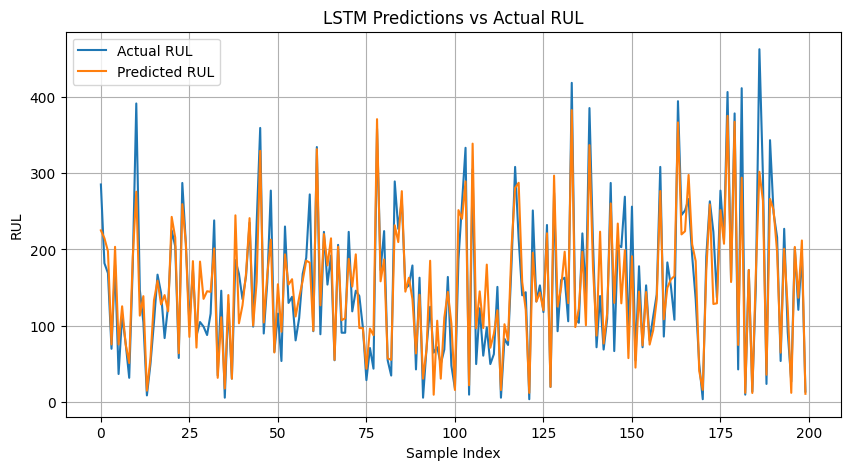

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test_seq[:200], label="Actual RUL")
plt.plot(y_pred_lstm[:200], label="Predicted RUL")
plt.title("LSTM Predictions vs Actual RUL")
plt.xlabel("Sample Index")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()

## 🌲 Step 4: Traditional ML Models (Random Forest & XGBoost)

In [6]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Prepare tabular data (2D) for traditional models
X_ml = train_data[feature_cols]
y_ml = train_data['RUL']
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_ml, y_train_ml)
y_pred_rf = rf.predict(X_test_ml)
mse_rf = mean_squared_error(y_test_ml, y_pred_rf)
mae_rf = mean_absolute_error(y_test_ml, y_pred_rf)
print(f"Random Forest - MSE: {mse_rf:.2f}, MAE: {mae_rf:.2f}")

# Train XGBoost
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train_ml, y_train_ml)
y_pred_xgb = xgb.predict(X_test_ml)
mse_xgb = mean_squared_error(y_test_ml, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test_ml, y_pred_xgb)
print(f"XGBoost - MSE: {mse_xgb:.2f}, MAE: {mae_xgb:.2f}")


Random Forest - MSE: 5203.80, MAE: 56.10
XGBoost - MSE: 5142.56, MAE: 55.28


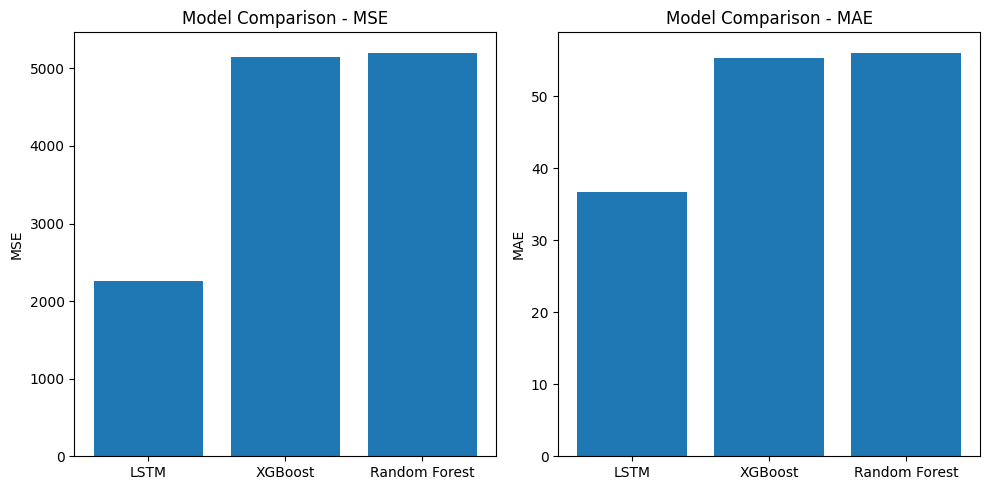

In [10]:
models = ['LSTM', 'XGBoost', 'Random Forest']
mse = [2262.48, 5142.56, 5203.80]
mae = [36.73, 55.28, 56.10]

x = range(len(models))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(x, mse, tick_label=models)
plt.title("Model Comparison - MSE")
plt.ylabel("MSE")

plt.subplot(1, 2, 2)
plt.bar(x, mae, tick_label=models)
plt.title("Model Comparison - MAE")
plt.ylabel("MAE")

plt.tight_layout()
plt.show()

## 📊 Step 5: Model Performance Comparison and Visualization

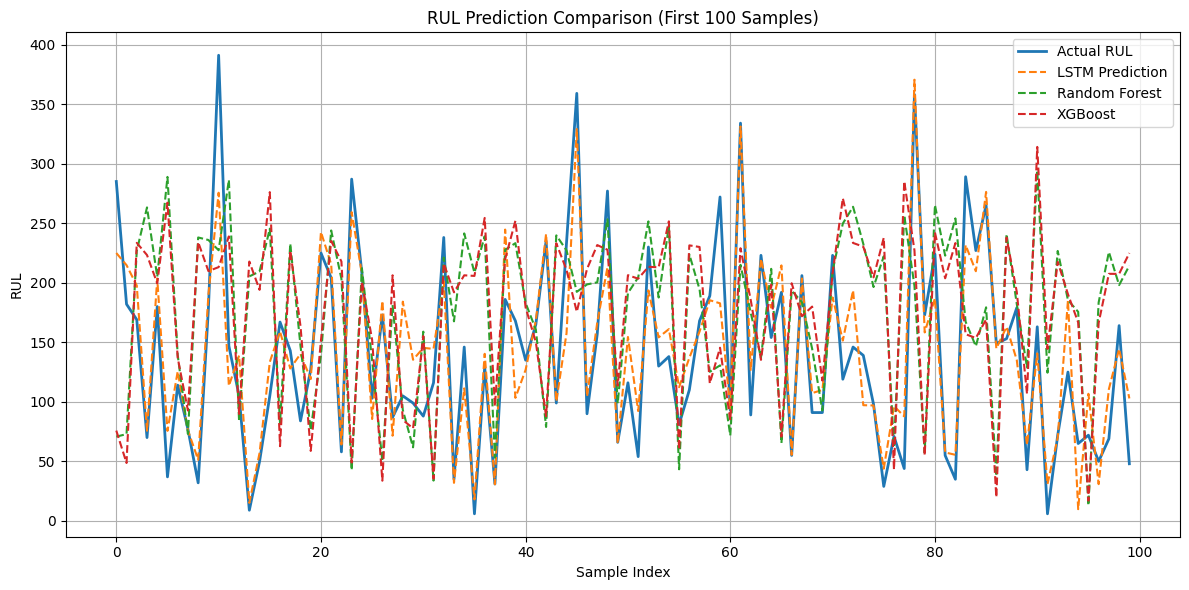

In [11]:
import matplotlib.pyplot as plt

# Combine all predictions and ground truth
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq[:100], label='Actual RUL', linewidth=2)
plt.plot(y_pred_lstm[:100], label='LSTM Prediction', linestyle='--')
plt.plot(y_pred_rf[:100], label='Random Forest', linestyle='--')
plt.plot(y_pred_xgb[:100], label='XGBoost', linestyle='--')
plt.title("RUL Prediction Comparison (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 💾 Step 6: Save Trained Models

In [15]:
import joblib
import os

model_dir = '/content/drive/My Drive/CMAPSS_Project/models/'
os.makedirs(model_dir, exist_ok=True)

# Save Random Forest and XGBoost models
joblib.dump(rf, os.path.join(model_dir, 'random_forest_model.pkl'))
joblib.dump(xgb, os.path.join(model_dir, 'xgboost_model.pkl'))
print("Saved Random Forest and XGBoost models.")

# Save LSTM model
model_lstm.save(os.path.join(model_dir, 'lstm_model.keras'))
print("Saved LSTM model.")


Saved Random Forest and XGBoost models.
Saved LSTM model.


## 📤 Step 7: Load Saved Models for Inference and Predict

In [17]:
from tensorflow.keras.models import load_model

# Load models
rf_loaded = joblib.load('/content/drive/My Drive/CMAPSS_Project/models/random_forest_model.pkl')
xgb_loaded = joblib.load('/content/drive/My Drive/CMAPSS_Project/models/xgboost_model.pkl')
lstm_loaded = load_model('/content/drive/My Drive/CMAPSS_Project/models/lstm_model.keras')

print("Models loaded successfully.")


Models loaded successfully.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [18]:
# Inference examples on 10 samples
new_X_tabular = X_test_ml[:10]
new_X_seq = X_test_seq[:10]

# Make predictions
pred_rf = rf_loaded.predict(new_X_tabular)
pred_xgb = xgb_loaded.predict(new_X_tabular)
pred_lstm = lstm_loaded.predict(new_X_seq).flatten()

# Show predictions
print("Random Forest Predictions:", pred_rf)
print("XGBoost Predictions:", pred_xgb)
print("LSTM Predictions:", pred_lstm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
Random Forest Predictions: [ 70.79  72.91 226.69 263.27 205.02 288.86 139.32  73.05 238.01 235.89]
XGBoost Predictions: [ 75.850235  48.640697 233.48393  223.24707  199.48567  267.2514
 137.0099    92.700386 234.08337  209.78897 ]
LSTM Predictions: [224.96727  214.75607  197.66599   75.73488  203.43254   75.63234
 125.59084   75.963524  51.32016  189.57549 ]


### Radar plot

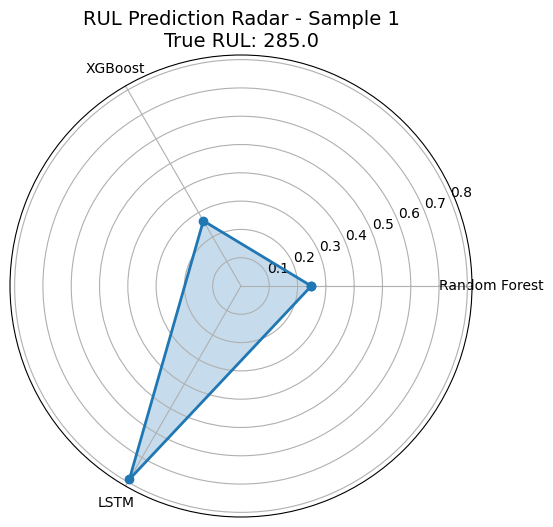

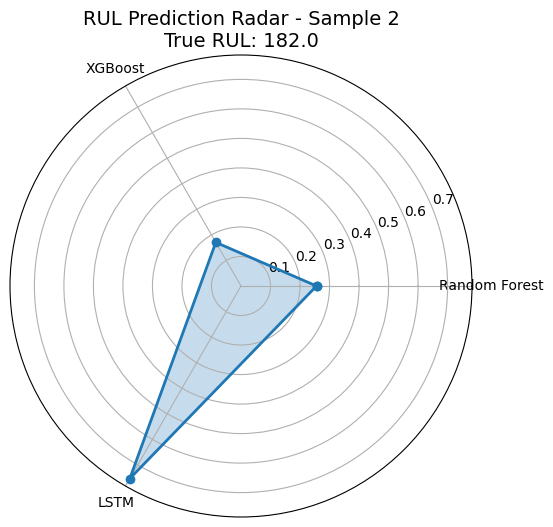

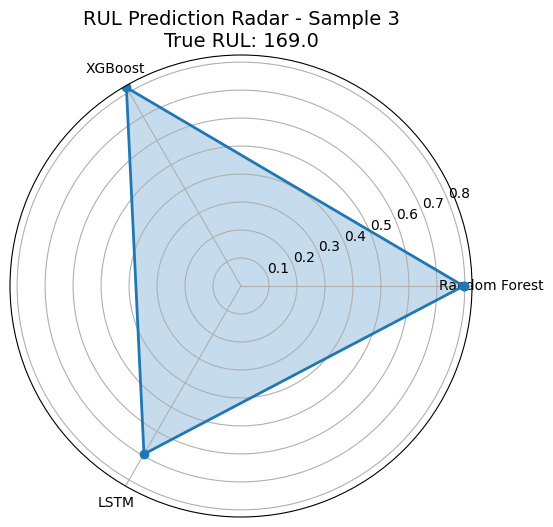

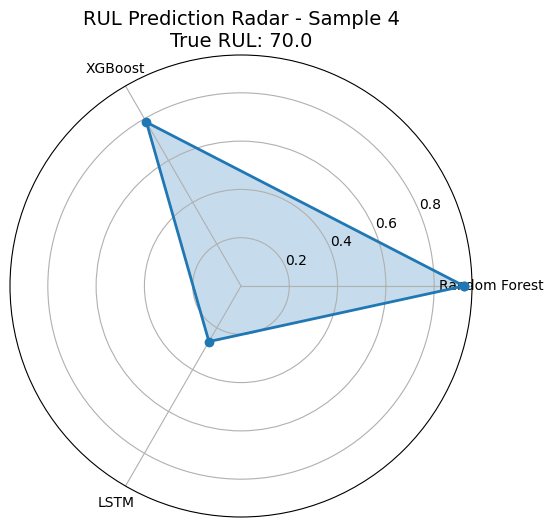

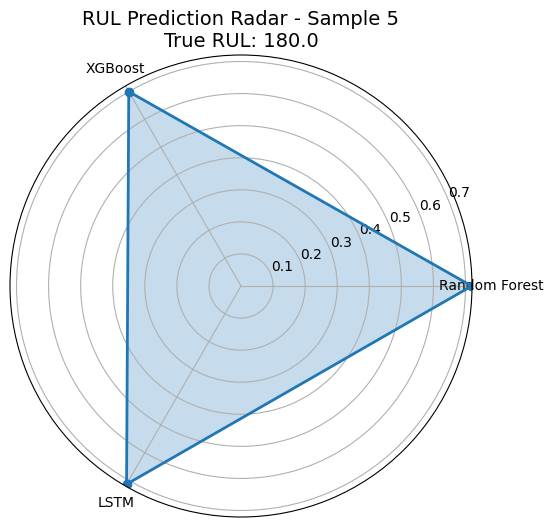

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Use your actual prediction outputs
rf_preds = pred_rf
xgb_preds = pred_xgb
lstm_preds = pred_lstm
true_rul = y_test_seq[:10]  # ground truth

def normalize(val, max_val): return val / max_val

labels = ['Random Forest', 'XGBoost', 'LSTM']
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

for i in range(5):
    sample_preds = [rf_preds[i], xgb_preds[i], lstm_preds[i]]
    sample_preds_norm = [normalize(p, max(true_rul)) for p in sample_preds]

    values = sample_preds_norm + [sample_preds_norm[0]]
    sample_angles = angles + [angles[0]]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(sample_angles, values, 'o-', linewidth=2)
    ax.fill(sample_angles, values, alpha=0.25)

    ax.set_thetagrids(np.degrees(angles), labels)
    ax.set_title(f'RUL Prediction Radar - Sample {i+1}\nTrue RUL: {true_rul[i]:.1f}', fontsize=14)
    ax.grid(True)
    plt.show()

### 🧮 Stacked bar chart for absolute error breakdown


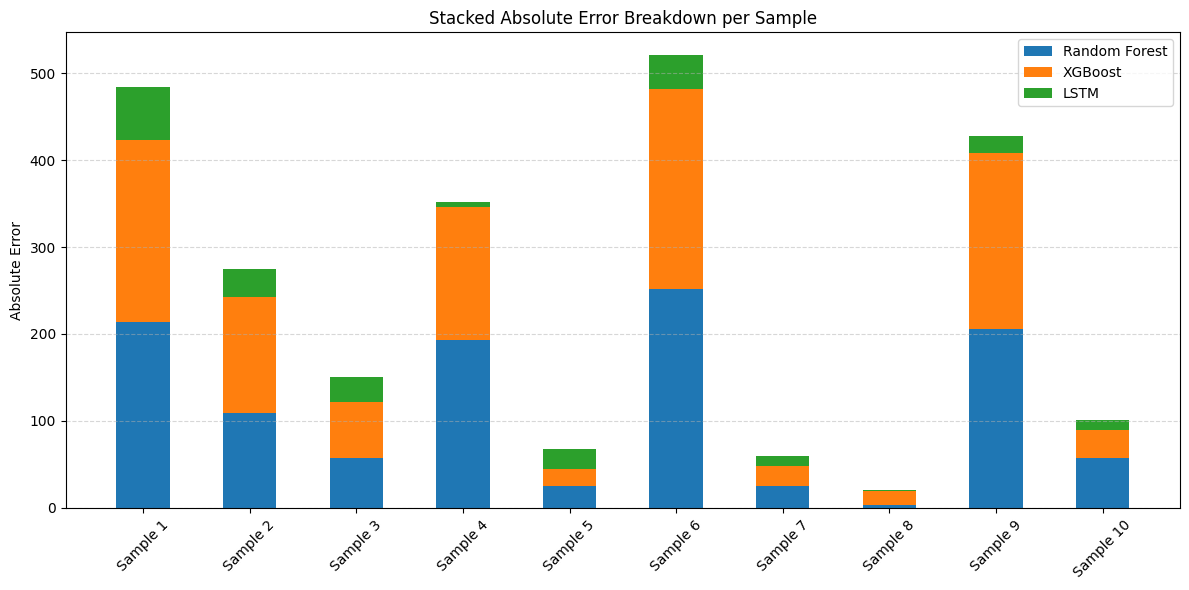

In [23]:
errors_rf = np.abs(pred_rf - y_test_seq[:10])
errors_xgb = np.abs(pred_xgb - y_test_seq[:10])
errors_lstm = np.abs(pred_lstm - y_test_seq[:10])

labels = [f"Sample {i+1}" for i in range(len(errors_rf))]

x = np.arange(len(labels))
width = 0.5

plt.figure(figsize=(12, 6))
plt.bar(x, errors_rf, width, label='Random Forest')
plt.bar(x, errors_xgb, width, bottom=errors_rf, label='XGBoost')
plt.bar(x, errors_lstm, width, bottom=errors_rf+errors_xgb, label='LSTM')

plt.ylabel('Absolute Error')
plt.title('Stacked Absolute Error Breakdown per Sample')
plt.xticks(x, labels, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 🧊 3D surface plot of error across model/sample grid



<ipython-input-25-e2ea99c952d7>:32: UserWarning: Glyph 129482 (\N{ICE CUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-25-e2ea99c952d7>:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129482 (\N{ICE CUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


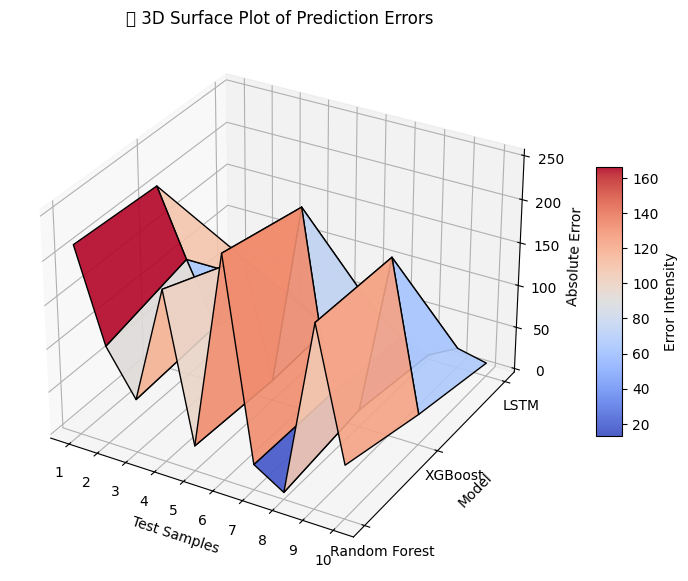

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Absolute error matrix (models × samples)
error_matrix = np.array([
    np.abs(pred_rf - y_test_seq[:10]),
    np.abs(pred_xgb - y_test_seq[:10]),
    np.abs(pred_lstm - y_test_seq[:10])
])

models = ['Random Forest', 'XGBoost', 'LSTM']
samples = [f'Sample {i+1}' for i in range(10)]
X, Y = np.meshgrid(np.arange(len(samples)), np.arange(len(models)))
Z = error_matrix

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap='coolwarm', edgecolor='k', alpha=0.9)

ax.set_xlabel('Test Samples')
ax.set_ylabel('Model')
ax.set_zlabel('Absolute Error')
ax.set_title('🧊 3D Surface Plot of Prediction Errors')
ax.set_yticks(np.arange(len(models)))
ax.set_yticklabels(models)
ax.set_xticks(np.arange(len(samples)))
ax.set_xticklabels([f'{i+1}' for i in range(10)])

fig.colorbar(surf, shrink=0.5, aspect=10, label='Error Intensity')
plt.tight_layout()
plt.show()